# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pickle 
import matplotlib.pyplot as plt

# from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.tree import plot_tree

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
input_files = []

for dirname, _, filenames in os.walk('dataset\CICIDS2017_improved'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        input_files.append(os.path.join(dirname, filename))
        
# print(input_files)
# print("\nImports done")

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset\CICIDS2017_improved\friday.csv
dataset\CICIDS2017_improved\monday.csv
dataset\CICIDS2017_improved\thursday.csv
dataset\CICIDS2017_improved\tuesday.csv
dataset\CICIDS2017_improved\wednesday.csv


# Cleanup for CSECICIDS2018_improved and CICIDS2017_improved

In [2]:
def label_mapper(label):
    # BENIGN, web_attack, ddos, botnet, infiltration, dos, ssh_bruteforce, ftp_bruteforce, others
    if label == 'BENIGN':
        return 0
    elif label.startswith("Web Attack"):
        return 1
    elif label.startswith("DDoS"):
        return 2
    elif label.startswith("Botnet"):
        return 3
    elif label.startswith("Infiltration") or label.startswith("Portscan") :
        return 4
    elif label.startswith("DoS"):
        return 5
    elif label.startswith("SSH"):
        return 6
    elif label.startswith("FTP"):
        return 7
    else:
        return 8


def dataset_cleaner(df):
    # change label
    df['Label'] = df['Label'].apply(label_mapper)
    
    # drop all categorical columns
    categorical_columns = df.select_dtypes(include=['object'])
    df.drop(columns=categorical_columns.columns.values, inplace=True)
    # id is unique for all, CISIAS notebook removed attempted category too
    df.drop(columns=['id', 'Attempted Category'], inplace=True)
    
#     print(df.columns.values)
    
    # drop all inf and other nan values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=0,how='any', inplace=True)
    
    return df

def get_target_features(df, test_size = 0.30):
    X = df.drop(['Label'], axis=1)
    y = df['Label']
    
    return train_test_split(X, y, test_size=test_size, random_state=42)

print("Functions defined")

Functions defined


# Load each file, do label clean up, run random forest  on it

In [3]:
# we will add to these 3 lists test set and predictions for all csv
# then we will merge them in one pandas object
# then we can do metrics on the dataset as a whole
# pros: will get whole dataset metrics
# cons: the 3 list and merged object may overflow 30 gb ram (praying it wont)
X_test_sets = []
y_test_sets = []

# MODELS
print("Initializing RF model")
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

i = 0

for f in input_files:
    
    i += 1
        
    print(f"{i}/{len(input_files)} CURRENT FILE: {f}\n")
    
    df = pd.read_csv(f)
    
    print(f"LOADED FILE {f}, STARTING CLEANUP\n")
    
    df = dataset_cleaner(df)
    
    print(f"CLEANUP DONE, STARTING SPLIT\n")
    
    X_train, X_test, y_train, y_test = get_target_features(df, 0.30)
    
    # no need for df now
    df = None
    gc.collect()
    
    X_test.to_csv(f"test_chunks/{i}X_test.csv", index=False)
    y_test.to_csv(f"test_chunks/{i}y_test.csv", index=False)
    
    # no need for the test sets either
    del X_test
    del y_test
    gc.collect()
    
    print("DONE WRITING TEST SETS TO FILES, STARTING TRAIN\n")
    
    # rf
    print("RUNNING RF MODEL TRAIN...\n")
    
    rf_model.fit(X_train, y_train)
    
    del X_train
    del y_train
    gc.collect()
    
    print(f"RF MODEL TRAINED ON FILE: {f} \n\n")
    

print(f"{i}/{len(input_files)} files worked on\n\n")

# clear memory
df = None
gc.collect()

Initializing RF model
1/5 CURRENT FILE: dataset\CICIDS2017_improved\friday.csv

LOADED FILE dataset\CICIDS2017_improved\friday.csv, STARTING CLEANUP

CLEANUP DONE, STARTING SPLIT

DONE WRITING TEST SETS TO FILES, STARTING TRAIN

RUNNING RF MODEL TRAIN...

RF MODEL TRAINED ON FILE: dataset\CICIDS2017_improved\friday.csv 


2/5 CURRENT FILE: dataset\CICIDS2017_improved\monday.csv

LOADED FILE dataset\CICIDS2017_improved\monday.csv, STARTING CLEANUP

CLEANUP DONE, STARTING SPLIT

DONE WRITING TEST SETS TO FILES, STARTING TRAIN

RUNNING RF MODEL TRAIN...

RF MODEL TRAINED ON FILE: dataset\CICIDS2017_improved\monday.csv 


3/5 CURRENT FILE: dataset\CICIDS2017_improved\thursday.csv

LOADED FILE dataset\CICIDS2017_improved\thursday.csv, STARTING CLEANUP

CLEANUP DONE, STARTING SPLIT

DONE WRITING TEST SETS TO FILES, STARTING TRAIN

RUNNING RF MODEL TRAIN...

RF MODEL TRAINED ON FILE: dataset\CICIDS2017_improved\thursday.csv 


4/5 CURRENT FILE: dataset\CICIDS2017_improved\tuesday.csv

LOADED 

0

# Prepare outputs for metric calculation

In [5]:
print("READING X TEST SETS AND PREDICTING\n")
gc.collect()

rf_predictions = []
y_tests = []

for curr in range(1,i+1):
    print(f"Reading X_test file {curr}/{i}\n")

    df_X = pd.read_csv(f"test_chunks/{curr}X_test.csv")
    
    print(f"Read {curr}-th X_test file, shape: {df_X.shape}\nPredicting and appending...")
    
    pred = rf_model.predict(df_X)
    rf_predictions.append(pred)
    
    del df_X 
    gc.collect()
    
    print(f"Done reading and predictiong on X_test file {curr}/{i}\n")
    

rf_predictions_joined = np.concatenate(rf_predictions)

# remove prediction list
del rf_predictions
gc.collect()

print("PREDICTION DONE USING RF MODELS: ")
print( rf_predictions_joined.shape)

print("\nREADING y_test FILES\n")

for curr in range(1,i+1):
    print(f"Reading y_test file {curr}/{i}\n")

    df_y = pd.read_csv(f"test_chunks/{curr}y_test.csv")
    
    print(f"Read {curr}-th y_test file, shape: {df_y.shape}\nAppending...")
    
    y_tests.append(df_y)
    
    del df_y
    gc.collect()
    
    print(f"Done reading and adding y_test file {curr}/{i}\n")
    
y_test_sets_joined = pd.concat(y_tests)

# remove y_tests
del y_tests
gc.collect()


print("DONE READING y_test FILES: ")
print(y_test_sets_joined.shape)

READING X TEST SETS AND PREDICTING

Reading X_test file 1/5

Read 1-th X_test file, shape: (164268, 84)
Predicting and appending...
Done reading and predictiong on X_test file 1/5

Reading X_test file 2/5

Read 2-th X_test file, shape: (111487, 84)
Predicting and appending...
Done reading and predictiong on X_test file 2/5

Reading X_test file 3/5

Read 3-th X_test file, shape: (108623, 84)
Predicting and appending...
Done reading and predictiong on X_test file 3/5

Reading X_test file 4/5

Read 4-th X_test file, shape: (96624, 84)
Predicting and appending...
Done reading and predictiong on X_test file 4/5

Reading X_test file 5/5

Read 5-th X_test file, shape: (148992, 84)
Predicting and appending...
Done reading and predictiong on X_test file 5/5

PREDICTION DONE USING RF MODELS: 
(629994,)

READING y_test FILES

Reading y_test file 1/5

Read 1-th y_test file, shape: (164268, 1)
Appending...
Done reading and adding y_test file 1/5

Reading y_test file 2/5

Read 2-th y_test file, shap

# Metrics

In [6]:
rf_accuracy = accuracy_score(y_test_sets_joined, rf_predictions_joined)
rf_f1 = f1_score(y_test_sets_joined, rf_predictions_joined, average='macro')
rf_precision = precision_score(y_test_sets_joined, rf_predictions_joined, average='macro')
rf_recall = recall_score(y_test_sets_joined, rf_predictions_joined, average='macro')

print("rf METRICS: \n")
print(f"ACCURACY: \t {rf_accuracy:.4f}")
print(f"F1 SCORE: \t {rf_f1:.4f}")
print(f"PRECISION: \t {rf_precision:.4f}")
print(f"RECALL: \t {rf_recall:.4f}")

rf METRICS: 

ACCURACY: 	 0.8383
F1 SCORE: 	 0.2945
PRECISION: 	 0.2797
RECALL: 	 0.3194


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Plots

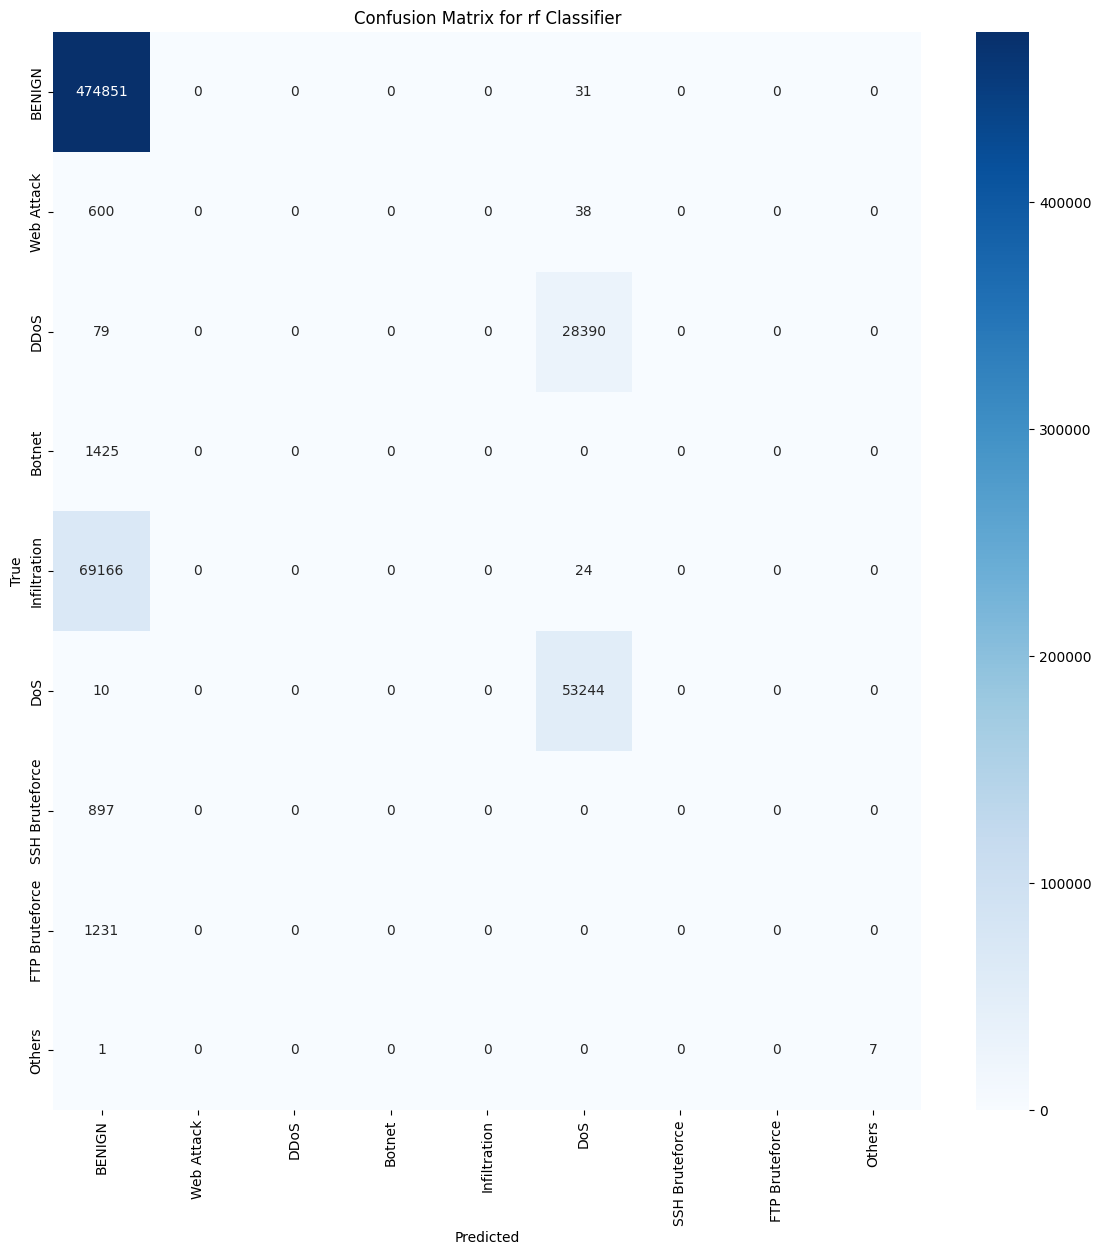

In [7]:
# Confusion Matrix
classes = ["BENIGN", "Web Attack", "DDoS", "Botnet", "Infiltration", "DoS", "SSH Bruteforce", "FTP Bruteforce", "Others"]
title = "Confusion Matrix for rf Classifier"

cm = confusion_matrix(y_test_sets_joined, rf_predictions_joined)
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(title)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
def save_model(model, filename="model.pkl"):
    with open(filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

In [9]:
def load_model(filename="model.pkl"):
    with open(filename, "rb") as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model

In [10]:
# Save to a pickle file            
save_model(rf_model,"models/rf.pickle")

Model saved to models/rf.pickle
